In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import random
import sys, os.path, os
from tqdm import tqdm
import pickle as pkl
from shapely.geometry import Point,Polygon
import dateutil.parser

import random
from datetime import datetime, timedelta

import sys, os.path, os
try:
    from google.colab import drive
    drive.mount('/content/drive')
    path_opencp="drive/Shareddrives/FAIRNESS/Colab/Librerias/PredictCode/"
    path_fairness="drive/Shareddrives/FAIRNESS/Colab/Librerias/"
    path_exp="drive/Shareddrives/FAIRNESS/Colab/Notebooks_for_topic/EXP0/SCRIPTS/"

except:

    path_opencp="g:\\Unidades compartidas\\FAIRNESS\\Colab\\Librerias\\PredictCode"
    path_fairness="g:\\Unidades compartidas\\FAIRNESS\\Colab\\Librerias"
    path_exp="g:\\Unidades compartidas\\FAIRNESS\\Colab\\Notebooks_for_topic\\EXP0\\SCRIPTS"

sys.path.insert(0, os.path.abspath(path_opencp))
sys.path.insert(0, os.path.abspath(path_fairness))
sys.path.insert(0, os.path.abspath(path_exp))

import open_cp
import open_cp.geometry
import matplotlib.pyplot as plt

try:
    os.chdir("drive/Shareddrives/FAIRNESS/Colab/Notebooks_for_topic/EXP0/DATOS")
except:
    os.chdir("g:\\Unidades compartidas\\FAIRNESS\\Colab\\Notebooks_for_topic\\EXP0\\DATOS")


Mounted at /content/drive


ERROR:open_cp.geometry:Failed to import `rtree`.


In [ ]:
def plot_intensity(intensity):
    fig, ax = plt.subplots(figsize=(11,5))
    im=ax.imshow(intensity, 'jet', interpolation='none', alpha=0.7,vmin=0)
    ax.invert_yaxis()
    plt.colorbar(im)
    plt.show(ax)

from scipy.stats import wasserstein_distance as emd

# **1**. BOGOTA DATA


In [ ]:
region=pkl.load(open('BOGOTA/definition_region.pkl', "rb"))
mask=pkl.load(open('BOGOTA/mascara_localidades.pkl', "rb"))
mask_protegidos=pkl.load(open('BOGOTA/mascara_protegidos.pkl', "rb"))
mask_noprotegidos=pkl.load(open('BOGOTA/mascara_noprotegidos.pkl', "rb"))
mask_zeros=pkl.load(open('BOGOTA/mascara_zeros.pkl', "rb"))

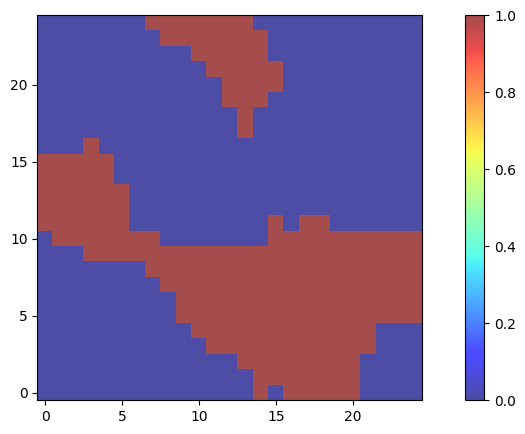

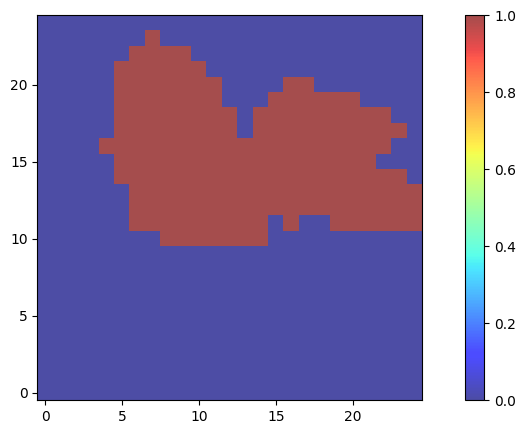

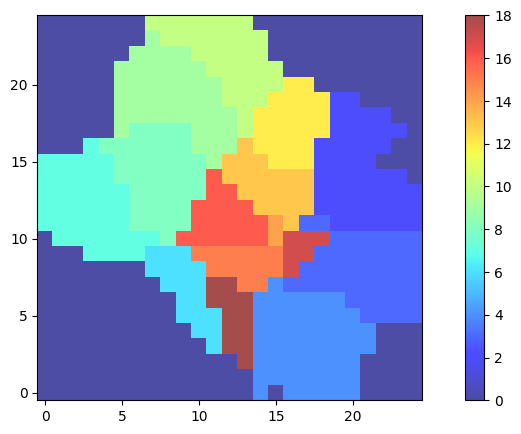

In [ ]:
total_mask={"p":mask_protegidos,"n_p":mask_noprotegidos}
plot_intensity(mask_protegidos)
plot_intensity(mask_noprotegidos)
plot_intensity(mask)

In [ ]:
DATA={
    "Naive":{
        "predictions":pkl.load(open('BOGOTA/NAIVE/predictions6.pkl', "rb")),
        "reals":pkl.load(open('BOGOTA/NAIVE/reals.pkl', "rb"))
    },
    "KDE":{
        "predictions":pkl.load(open('BOGOTA/KDE/predictions6.pkl', "rb")),
        "reals":pkl.load(open('BOGOTA/KDE/reals.pkl', "rb"))
    },
    "SEPP":{
        "predictions":pkl.load(open('BOGOTA/SEPP/predictions_grid.pkl', "rb")),
        "reals":pkl.load(open('BOGOTA/SEPP/reals_grid.pkl', "rb"))
    }
}

In [ ]:
days=DATA["Naive"]["predictions"].keys()

In [ ]:
from fairness_measures.measures import f_benefit as f_benefit
from fairness_measures import utils, measures
fairness_type=[measures.MM,measures.gini_coeff]
fairness_name=["Maxmin","Gini"]

In [ ]:
Fairness_table_bogota=pd.DataFrame(columns=["Model","Dia","tipo_fairness","Valor","B_protected","B_no_protected","EMD"])

for dia in tqdm(days):

    for model in ["Naive","KDE","SEPP"]:

        if model=="SEPP":
            dia=dia.date()


        B_protected=f_benefit(total_mask["p"],DATA[model]["reals"][dia],DATA[model]["predictions"][dia])
        B_no_protected=f_benefit(total_mask["n_p"],DATA[model]["reals"][dia],DATA[model]["predictions"][dia])
        EMD_value=emd(DATA[model]["reals"][dia].flatten(),DATA[model]["predictions"][dia].flatten())


        for k,k_name in zip(fairness_type,fairness_name):

            valor=k(total_mask,f_benefit,DATA[model]["predictions"][dia],DATA[model]["reals"][dia])

            if model=="SEPP":
                Fairness_table_bogota.loc[len(Fairness_table_bogota)]=[model,dia,k_name,valor,B_protected,B_no_protected,EMD_value]
            else:
                Fairness_table_bogota.loc[len(Fairness_table_bogota)]=[model,dia.date(),k_name,valor,B_protected,B_no_protected,EMD_value]

Fairness_table_bogota['tipo_fairness'] = Fairness_table_bogota['tipo_fairness'].str.replace('Maxmin', 'Max-Min')

100%|██████████| 30/30 [00:01<00:00, 20.32it/s]


In [ ]:
Fairness_table_bogota["Valor"]=[ Fairness_table_bogota.iloc[i,3]*2 if Fairness_table_bogota.iloc[i,2]=='Gini' else Fairness_table_bogota.iloc[i,3] for i in range(len(Fairness_table_bogota))]
Fairness_table_bogota[["Model","tipo_fairness","Valor","EMD"]].groupby(["tipo_fairness","Model"]).describe()#.agg({"Valor":"mean","EMD":"mean"})

Valor                                                    \
                    count      mean       std       min       25%       50%   
tipo_fairness Model                                                           
Gini          KDE    30.0  0.208716  0.060273  0.090571  0.170441  0.205294   
              Naive  30.0  0.187634  0.057262  0.099579  0.140937  0.178184   
              SEPP   30.0  0.167057  0.056116  0.037028  0.128670  0.181041   
Max-Min       KDE    30.0  0.001630  0.000467  0.000744  0.001377  0.001564   
              Naive  30.0  0.001454  0.000430  0.000820  0.001167  0.001402   
              SEPP   30.0  0.001213  0.000416  0.000301  0.000902  0.001229   

                                          EMD                                \
                          75%       max count      mean       std       min   
tipo_fairness Model                                                           
Gini          KDE    0.237140  0.368685  30.0  0.002135  0.000190  0.001839   
              Naive  0.215093  0.344244  30.0  0.002215  0.000186  0.001944   
              SEPP   0.206445  0.307986  30.0  0.001822  0.000222  0.001513   
Max-Min       KDE    0.001841  0.002769  30.0  0.002135  0.000190  0.001839   
              Naive  0.001701  0.002552  30.0  0.002215  0.000186  0.001944   
              SEPP   0.001492  0.002149  30.0  0.001822  0.000222  0.001513   

                                                             
                          25%       50%       75%       max  
tipo_fairness Model                                          
Gini          KDE    0.002020  0.002118  0.002229  0.002736  
              Naive  0.002071  0.002199  0.002286  0.002703  
              SEPP   0.001681  0.001745  0.001932  0.002499  
Max-Min       KDE    0.002020  0.002118  0.002229  0.002736  
              Naive  0.002071  0.002199  0.002286  0.002703  
              SEPP   0.001681  0.001745  0.001932  0.002499

# **2**. CHICAGO DATA

In [ ]:
region=pkl.load(open('CHICAGO/chicago_definition_region.pkl', "rb"))
#mask=pkl.load(open('mascara_localidades.pkl', "rb"))
mask_protegidos=pkl.load(open('CHICAGO/chichago_mascara_protegidos.pkl', "rb"))
mask_noprotegidos=pkl.load(open('CHICAGO/chichago_mascara_noprotegidos.pkl', "rb"))
mask_zeros=pkl.load(open('CHICAGO/chichago_mascara_zeros.pkl', "rb"))

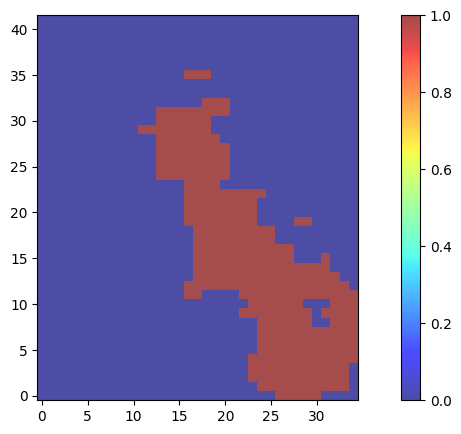

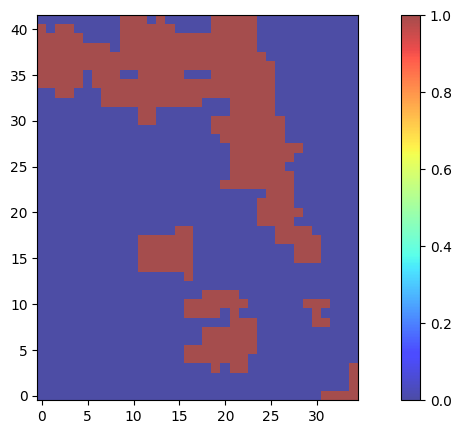

In [ ]:
total_mask={"p":mask_protegidos,"n_p":mask_noprotegidos}
plot_intensity(mask_protegidos)
plot_intensity(mask_noprotegidos)

In [ ]:
DATA={
    "Naive":{
        "predictions":pkl.load(open('CHICAGO/NAIVE/predictions2023.pkl', "rb")),
        "reals":pkl.load(open('CHICAGO/NAIVE/reals.pkl', "rb"))
    },
    "KDE":{
        "predictions":pkl.load(open('CHICAGO/KDE/predictions2023.pkl', "rb")),
        "reals":pkl.load(open('CHICAGO/KDE/reals.pkl', "rb"))
    },
    "SEPP":{
        "predictions":pkl.load(open('CHICAGO/SEPP/predictions_grid.pkl', "rb")),
        "reals":pkl.load(open('CHICAGO/SEPP/reals_grid.pkl', "rb"))
    }
}

In [ ]:
days=DATA["KDE"]["predictions"].keys()
days=[i for i in days]
import datetime
days=set(set(days)-set([datetime.datetime(2023, 5, 31, 0, 0)]))

from fairness_measures.measures import f_benefit as f_benefit
from fairness_measures import utils, measures
fairness_type=[measures.MM,measures.gini_coeff]
fairness_name=["Maxmin","Gini"]

In [ ]:
Fairness_table_chicago=pd.DataFrame(columns=["Model","Dia","tipo_fairness","Valor","B_protected","B_no_protected","EMD"])

for dia in tqdm(days):

    for model in ["Naive","KDE","SEPP"]:

        if model=="SEPP":
            dia=dia.date()


        B_protected=f_benefit(total_mask["p"],DATA[model]["reals"][dia],DATA[model]["predictions"][dia])
        B_no_protected=f_benefit(total_mask["n_p"],DATA[model]["reals"][dia],DATA[model]["predictions"][dia])
        EMD_value=emd(DATA[model]["reals"][dia].flatten(),DATA[model]["predictions"][dia].flatten())


        for k,k_name in zip(fairness_type,fairness_name):

            valor=k(total_mask,f_benefit,DATA[model]["predictions"][dia],DATA[model]["reals"][dia])

            if model=="SEPP":
                Fairness_table_chicago.loc[len(Fairness_table_chicago)]=[model,dia,k_name,valor,B_protected,B_no_protected,EMD_value]
            else:
                Fairness_table_chicago.loc[len(Fairness_table_chicago)]=[model,dia.date(),k_name,valor,B_protected,B_no_protected,EMD_value]

Fairness_table_chicago['tipo_fairness'] = Fairness_table_chicago['tipo_fairness'].str.replace('Maxmin', 'Max-Min')

100%|██████████| 150/150 [00:08<00:00, 18.49it/s]


In [ ]:
Fairness_table_chicago["Valor"]=[ Fairness_table_chicago.iloc[i,3]*2 if Fairness_table_chicago.iloc[i,2]=='Gini' else Fairness_table_chicago.iloc[i,3] for i in range(len(Fairness_table_chicago))]
Fairness_table_chicago[["Model","tipo_fairness","Valor","EMD"]].groupby(["tipo_fairness","Model"]).describe()#.agg({"Valor":"mean","EMD":"mean"})

Valor                                                    \
                     count      mean       std       min       25%       50%   
tipo_fairness Model                                                            
Gini          KDE    150.0  0.058293  0.035195  0.003080  0.032052  0.054109   
              Naive  150.0  0.059979  0.034891  0.003070  0.035365  0.058307   
              SEPP   150.0  0.079941  0.037031  0.006831  0.057173  0.078188   
Max-Min       KDE    150.0  0.000217  0.000132  0.000010  0.000117  0.000204   
              Naive  150.0  0.000222  0.000131  0.000011  0.000124  0.000215   
              SEPP   150.0  0.000264  0.000124  0.000023  0.000186  0.000264   

                                           EMD                                \
                          75%       max  count      mean       std       min   
tipo_fairness Model                                                            
Gini          KDE    0.077046  0.173867  150.0  0.000764  0.000050  0.000625   
              Naive  0.077535  0.187443  150.0  0.000755  0.000048  0.000623   
              SEPP   0.101143  0.173866  150.0  0.000547  0.000038  0.000465   
Max-Min       KDE    0.000281  0.000633  150.0  0.000764  0.000050  0.000625   
              Naive  0.000286  0.000673  150.0  0.000755  0.000048  0.000623   
              SEPP   0.000344  0.000574  150.0  0.000547  0.000038  0.000465   

                                                             
                          25%       50%       75%       max  
tipo_fairness Model                                          
Gini          KDE    0.000728  0.000760  0.000796  0.000883  
              Naive  0.000720  0.000754  0.000790  0.000880  
              SEPP   0.000522  0.000546  0.000565  0.000633  
Max-Min       KDE    0.000728  0.000760  0.000796  0.000883  
              Naive  0.000720  0.000754  0.000790  0.000880  
              SEPP   0.000522  0.000546  0.000565  0.000633

# **3**. SIMULATED DATA

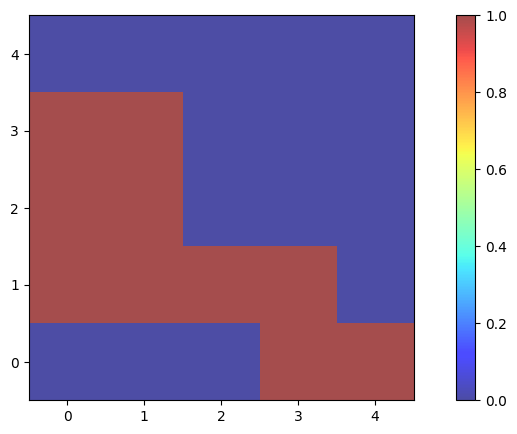

In [ ]:
### mascara variable protegida, incoming distribution

mask=np.array([[False,False,False,True,True],
               [True,True,True,True,False],
               [True,True,False,False,False],
               [True,True,False,False,False],
               [False,False,False,False,False],
               ])
plot_intensity(mask)
total_mask=utils.generate_total_masks({"p":mask})

from global_vars import x_min,x_max,y_min,y_max,grid_size,days_time_unit

## definicion de la region
region = open_cp.RectangularRegion(x_min,x_max, y_min,y_max)

In [ ]:
from fairness_measures.measures import f_benefit as f_benefit
fairness_type=[measures.variance, measures.MM,measures.gini_coeff]

Path_models_sepp="MODELOS/SEPP/"
Path_models_naive="MODELOS/NAIVE/"
Path_models_kde="MODELOS/KDE/"

path_file_fairness="RESULTADOS/fairnes_measures2.xlsx"

if not os.path.exists(path_file_fairness):

    Fairness_table_simulated=pd.DataFrame(columns=["Model","Data_id","Dia","tipo_fairness","Valor","EMD","B_protected","B_no_protected","B_total"])
    fairness_name=["variance", "MaxMin","gini"]

    for id in tqdm(range(30)):


        for path_models,m_name in zip([Path_models_sepp,Path_models_naive,Path_models_kde],["SEPP","NAIVE","KDE"]):

            try:
                folder_data_id=os.path.join(path_models,"Data_"+str(id))
                preds=pkl.load(open(os.path.join(folder_data_id,"predictions.pkl"), "rb"))
                reales=pkl.load(open(os.path.join(folder_data_id,"reals.pkl"), "rb"))

                for dia in preds.keys():

                    try:

                        # EMD_value=EMD(preds[dia],reales[dia],0.2)
                        EMD_value=emd(preds[dia].flatten(),reales[dia].flatten())

                    except:

                        EMD_value=np.NAN

                    B_protected=f_benefit(total_mask["p"],reales[dia],preds[dia])

                    B_no_protected=f_benefit(total_mask["p_r"],reales[dia],preds[dia])

                    B_total=f_benefit(np.ones_like(mask),reales[dia],preds[dia])

                    for k,k_name in zip(fairness_type,fairness_name):

                        valor=k(total_mask,f_benefit,preds[dia],reales[dia])

                        Fairness_table_simulated.loc[len(Fairness_table_simulated)]=[m_name,id,dia,k_name,valor,EMD_value,B_protected,B_no_protected,B_total]
            except:
                continue

    Fairness_table_simulated.to_excel(path_file_fairness,index=False)

else:
    Fairness_table_simulated=pd.read_excel(path_file_fairness)

In [ ]:
Fairness_table_simulated=Fairness_table_simulated.query("tipo_fairness!='variance'")
Fairness_table_simulated['tipo_fairness'] = Fairness_table_simulated['tipo_fairness'].str.replace('MaxMin', 'Max-Min')
Fairness_table_simulated['tipo_fairness'] = Fairness_table_simulated['tipo_fairness'].str.replace('gini', 'Gini')
Fairness_table_simulated["Week number"]=Fairness_table_simulated["Dia"].dt.isocalendar().week.astype(int)
Fairness_table_simulated["Valor"]=[ Fairness_table_simulated.iloc[i,4]*2 if Fairness_table_simulated.iloc[i,3]=='gini' else Fairness_table_simulated.iloc[i,4] for i in range(len(Fairness_table_simulated))]

In [ ]:
Fairness_table_simulated=Fairness_table_simulated.groupby(["Week number","Model","Data_id","tipo_fairness"]).agg({"Valor":"mean",
                                                                                      "EMD":"mean"}).reset_index()
Fairness_table_simulated.replace("NAIVE","Naive",inplace=True)
Fairness_table_simulated[["Model","tipo_fairness","Valor","EMD"]].groupby(["tipo_fairness","Model"]).describe()

Valor                                                    \
                      count      mean       std       min       25%       50%   
tipo_fairness Model                                                             
Gini          KDE    1560.0  0.212247  0.147709  0.027437  0.104977  0.151446   
              Naive  1560.0  0.206309  0.146454  0.031648  0.102346  0.145785   
              SEPP   1560.0  0.216796  0.146139  0.030141  0.112401  0.156504   
Max-Min       KDE    1560.0  0.032000  0.014856  0.005534  0.020339  0.029551   
              Naive  1560.0  0.029012  0.013547  0.005272  0.018087  0.026781   
              SEPP   1560.0  0.032268  0.017144  0.005378  0.019647  0.028654   

                                            EMD                                \
                          75%       max   count      mean       std       min   
tipo_fairness Model                                                             
Gini          KDE    0.256435  0.500000  1560.0  0.025520  0.007659  0.008211   
              Naive  0.241473  0.499274  1560.0  0.029663  0.009589  0.007289   
              SEPP   0.257504  0.498895  1560.0  0.023664  0.007117  0.009300   
Max-Min       KDE    0.042244  0.084071  1560.0  0.025520  0.007659  0.008211   
              Naive  0.038338  0.079754  1560.0  0.029663  0.009589  0.007289   
              SEPP   0.041691  0.130962  1560.0  0.023664  0.007117  0.009300   

                                                             
                          25%       50%       75%       max  
tipo_fairness Model                                          
Gini          KDE    0.019342  0.024891  0.031024  0.049350  
              Naive  0.021927  0.029802  0.036993  0.055139  
              SEPP   0.018170  0.022261  0.027972  0.051693  
Max-Min       KDE    0.019342  0.024891  0.031024  0.049350  
              Naive  0.021927  0.029802  0.036993  0.055139  
              SEPP   0.018170  0.022261  0.027972  0.051693

# **4**. Box-Cox PLOT DATA

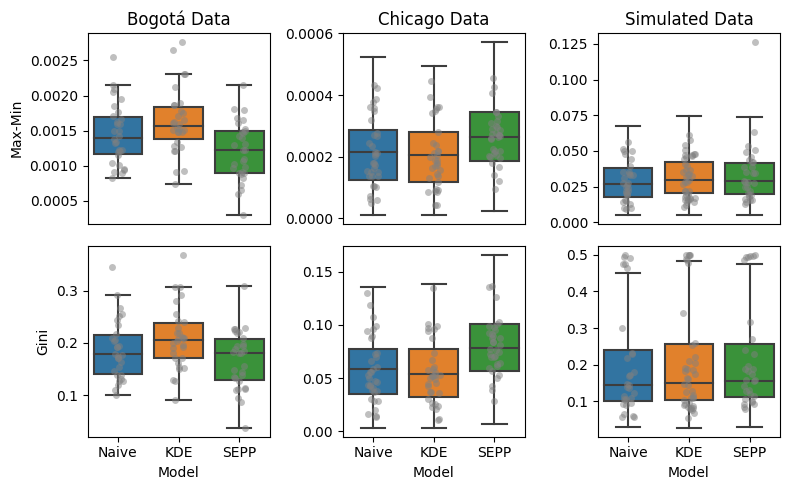

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que tienes los DataFrames df1, df2 y df3

# Combina los DataFrames verticalmente
Fairness_table_bogota['Origen']='Bogotá'
Fairness_table_chicago['Origen']='Chicago'
Fairness_table_simulated['Origen']='Simulated'
combined_df = pd.concat([Fairness_table_bogota, Fairness_table_chicago, Fairness_table_simulated], keys=['Bogotá', 'Chicago', 'Simulated'])

# Reinicia el índice para tener un índice único
combined_df.reset_index(inplace=True)

fig, axes = plt.subplots(2, 3, figsize=(8, 5))

for i, col in enumerate(['Bogotá', 'Chicago', 'Simulated']):
    for j, cat in enumerate(['Max-Min', 'Gini']):
        subset = combined_df[(combined_df['Origen'] == col)&(combined_df['tipo_fairness'] == cat)]

        sns.stripplot(x="Model"
                      , y="Valor"
                      , data=subset.head(100)
                      , order=['Naive',"KDE",'SEPP']
                      , alpha=0.5
                      , color='grey'
                      , jitter=True
                      , ax=axes[j, i])

        if (j==0):
          g=sns.boxplot(
                    x='Model',
                    y='Valor',
                    data=subset,
                    order=['Naive',"KDE",'SEPP'],
                    ax=axes[j, i],
                    showfliers=False,
                    dodge=False
                    )
          axes[j, i].set_title(f'{col} Data')
          g.set_xticks([])
          axes[j, i].set_ylabel('')
          axes[j, i].set_xlabel('')
          if cat=='Gini':
            g.set_ylim(0, 0.5)
          else:
            None
          #g.set_yticks([])
        else:
          g=sns.boxplot(
                    x='Model',
                    y='Valor',
                    data=subset,
                    order=['Naive',"KDE",'SEPP'],
                    ax=axes[j, i],
                    showfliers=False,
                    dodge=False
                )
          #if cat=='Gini':
          #  g.set_ylim(0, 0.5)
          #else:
          #  None
          axes[j, i].set_xlabel('Model')
          axes[j, i].set_ylabel('')
        if ((i==0 and j==0) or (i==0 and j==1)):
          axes[j, i].set_ylabel(cat)



plt.tight_layout()
plt.show()

# **5**. Histogram PLOT DATA

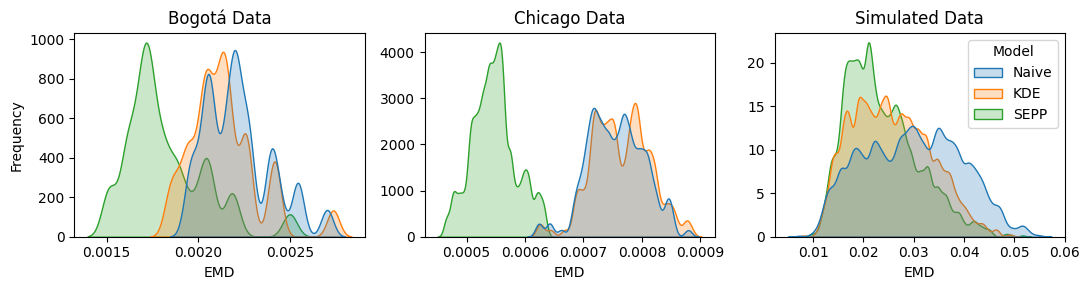

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que tienes los DataFrames df1, df2 y df3

# Combina los DataFrames verticalmente
Fairness_table_bogota['Origen']='Bogotá'
Fairness_table_chicago['Origen']='Chicago'
Fairness_table_simulated['Origen']='Simulated'
combined_df = pd.concat([Fairness_table_bogota, Fairness_table_chicago, Fairness_table_simulated], keys=['Bogotá', 'Chicago', 'Simulated'])

# Reinicia el índice para tener un índice único
combined_df.reset_index(inplace=True)

fig, axes = plt.subplots(1, 3, figsize=(11, 3))

for i, col in enumerate(['Bogotá', 'Chicago', 'Simulated']):
  subset = combined_df[(combined_df['Origen'] == col)].reset_index(drop=True)

  logic=False
  if i==2:
    logic=True


  g=sns.kdeplot(subset
              #,element="step"
              #,kde=True
              ,legend=logic
              ,x="EMD"
              ,hue="Model"
              ,hue_order=['Naive','KDE','SEPP']
              ,fill=True
              ,ax=axes[i]
              ,bw_adjust=0.4)
  if i!=0:
    axes[i].set_ylabel('')
    #g.set_xticks([])
  else:
    axes[i].set_ylabel('Frequency')

  axes[i].set_title(f'{col} Data')

plt.tight_layout()
plt.show()

# **6**. Fairness PLOT DATA

In [ ]:
from matplotlib.ticker import PercentFormatter

In [ ]:
dfs_bogota=[]
for i in range(0,100,5):
    df=Fairness_table_bogota.copy()
    df["Protected Group Disparity"]=(df["B_protected"]*(1+i/100) > df["B_no_protected"]).astype(int)
    df["Threshold Range"]=str(i)+"%"
    dfs_bogota.append(df)
dfs_bogota=pd.concat(dfs_bogota)

dfs_chicago=[]
for i in range(0,100,5):
    df=Fairness_table_chicago.copy()
    df["Protected Group Disparity"]=(df["B_no_protected"]*(1+i/100) > df["B_protected"]).astype(int)
    df["Threshold Range"]=str(i)+"%"
    dfs_chicago.append(df)
dfs_chicago=pd.concat(dfs_chicago)

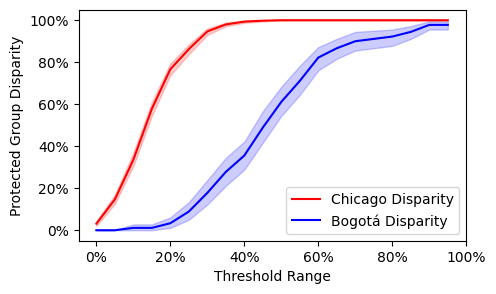

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
g=sns.lineplot(dfs_chicago,x="Threshold Range",y="Protected Group Disparity",color="r",errorbar="ci",estimator="mean",err_kws={"alpha":0.2},label='Chicago Disparity')
g=sns.lineplot(dfs_bogota,x="Threshold Range",y="Protected Group Disparity",color="b",errorbar="ci",estimator="mean",err_kws={"alpha":0.2},label='Bogotá Disparity')
g.axes.yaxis.set_major_formatter(PercentFormatter(1,decimals=0))
plt.xticks(ticks=["0%","20%","40%","60%","80%","100%"])
plt.legend(loc='lower right')
plt.show()